# LLIE Comparison
## General Flow
 - Create bash file to clone llie methods
 - Setup environment
 - Implement LLIE methods
 - Select llie method

## Bash script setup

In [58]:
%%writefile setup.sh
# Write the setup script into a shell file

#!/bin/bash

echo "Cloning LLIE repositories..."
mkdir -p llie_methods
cd llie_methods || exit

# Clone only if not already cloned
[ ! -d "colie" ] && git clone https://github.com/ctom2/colie.git
[ ! -d "SCI" ] && git clone https://github.com/tengyu1998/SCI.git
[ ! -d "Retinexformer" ] && git clone https://github.com/caiyuanhao1998/Retinexformer.git
[ ! -d "Zero-DCE" ] && git clone https://github.com/Li-Chongyi/Zero-DCE.git
cd ..

pip install onnxruntime-gpu || pip install onnxruntime
pip install insightface

echo "Checking if guidedFilter is available..."

python3 -c "from cv2.ximgproc import guidedFilter" 2>/dev/null

if [ $? -ne 0 ]; then
    echo "guidedFilter not found — installing OpenCV contrib and dependencies..."

    pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python
    pip install --force-reinstall opencv-contrib-python

    pip install insightface scikit-image matplotlib tqdm

    echo "Installation complete. Please manually restart the runtime now."
else
    echo "guidedFilter is already available — skipping OpenCV reinstall."
fi

echo "Setup complete."


Overwriting setup.sh


## Environment Setup

In [59]:
# Local dataset path setup (Ubuntu)
darkface_dir = "darkface/images"
label_dir = "darkface/labels"
output_dir = "output/enhanced_images"
results_dir = "results"

# Check if dataset is visible
from glob import glob
from IPython.display import display
import os

sample_imgs = glob(os.path.join(darkface_dir, "*.png"))
print(f"Found {len(sample_imgs)} images in {darkface_dir}")
display(sample_imgs[:5])


Found 100 images in darkface/images


['darkface/images/17.png',
 'darkface/images/33.png',
 'darkface/images/22.png',
 'darkface/images/63.png',
 'darkface/images/4.png']

In [60]:
!bash setup.sh

Cloning LLIE repositories...
Checking if guidedFilter is available...
guidedFilter is already available — skipping OpenCV reinstall.
Setup complete.


In [61]:
import os
import cv2
import json
import shutil
# from retinaface import RetinaFace
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
# from retinaface import RetinaFace
# ---------------------------
# User Configuration
# ---------------------------
output_dir = "./output/enhanced_images"
results_dir = "./results"

# ---------------------------
# Load Dark Face Dataset
# ---------------------------
def load_darkface_images(directory):
    image_paths = sorted(glob(os.path.join(directory, "**/*.png"), recursive=True))
    if len(image_paths) == 0:
        raise FileNotFoundError(f"No images found in {directory}. Please check your dataset path.")
    return image_paths

# LLIE Implementation

## Belyaev Method

In [62]:
#######################################################################################
#       This code was developed by Dr Alexander Belyaev @ Heriot-Watt University      #
#       The original code was then converted to python code by Dean Rowlett           #
#######################################################################################
#
#
#
#######################################################################################
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cv2.ximgproc import guidedFilter
from skimage import img_as_float32
import matplotlib.pyplot as plt

def imbeam(rgb_in, p=0.8, r=0.01, debug=False, label=""):
    # Convert to float32
    rgb_in = img_as_float32(rgb_in)

    if debug:
        print(f"[{label}] Input range: min={rgb_in.min():.4f}, max={rgb_in.max():.4f}")

    hsv = cv2.cvtColor(rgb_in, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]

    # Guided filter expects 8-bit
    v_uint8 = np.uint8(v * 255)
    guided = guidedFilter(v_uint8, v_uint8, radius=15, eps=1e-6)
    guided = guided / 255.0

    v_new = v / (np.power(guided, p) + r)
    v_new = np.clip(v_new, 0, 1)
    hsv[:, :, 2] = v_new

    rgb_out = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    if debug:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(rgb_in)
        axs[0].set_title(f"Original RGB — {label}")
        axs[1].imshow(rgb_out)
        axs[1].set_title(f"Enhanced RGB — {label}")
        for ax in axs: ax.axis("off")
        plt.show()

    return rgb_out





## CoLIE Method

In [63]:
def run_colie(
    input_folder="drive/MyDrive/darkface-test_images",
    output_folder="output/enhanced_images/CoLIE",
    alpha=1.0,
    beta=0.1,
    gamma=0.1,
    delta=0.001
):
    """
    Runs the CoLIE enhancement script with default or custom parameters.

    Parameters:
        input_folder (str): Path to low-light images.
        output_folder (str): Path where enhanced images will be saved.
        alpha, beta, gamma, delta (float): Loss function weights.
    """
    command = (
        f"python3 llie_methods/colie/colie.py "
        f"--input_folder {input_folder} "
        f"--output_folder {output_folder} "
        f"--alpha {alpha} --beta {beta} --gamma {gamma} --delta {delta}"
    )
    print(f"[INFO] Running CoLIE:\n{command}\n")
    os.system(command)

# Face Recognition

In [64]:
# ---------------------------
# Run RetinaFace Detection
# ---------------------------
def detect_faces(img_dir, result_path):
    from insightface.app import FaceAnalysis

    image_paths = sorted(glob(os.path.join(img_dir, "**/*.jpg"), recursive=True))
    stats = {}  # { filename: [ [x1, y1, x2, y2], ... ] }

    app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    app.prepare(ctx_id=0, det_size=(640, 640))

    print(f"Running face detection on {len(image_paths)} images...")

    for img_path in tqdm(image_paths, desc="Detecting faces"):
        filename = os.path.basename(img_path)
        try:
            img = cv2.imread(img_path)
            faces = app.get(img)
            boxes = [face.bbox.tolist() for face in faces]
            stats[filename] = boxes
        except Exception as e:
            print(f"Error on {filename}: {e}")
            stats[filename] = []

    with open(result_path, "w") as f:
        json.dump(stats, f, indent=2)

    print(f"Saved detection boxes to: {result_path}")


In [65]:
import onnxruntime
print(onnxruntime.get_available_providers())


['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


# LLIE Pipeline

In [66]:
!ls
!echo "---------------------"

!ls llie_methods/colie/

!echo "---------------------"
!cd llie_methods/colie/

!echo "---------------------"
!ls ../../content/drive/MyDrive/darkface-test_images/

!echo "---------------------"
!ls darkface/images

!echo "---------------------"
# !python3 llie_methods/colie/colie.py --input_folder darkface/images --output_folder output/enhanced_images/CoLIE --alpha 1 --beta 0.1 --gamma 0.1 --delta 0.001


darkface	       llie_methods  output	       results
llie_comparison.ipynb  LLIE_Methods  requirements.txt  setup.sh
---------------------
colie.py  figs	     input    loss.py	      __pycache__  siren.py
color.py  filter.py  LICENSE  notebook.ipynb  README.md    utils.py
---------------------
---------------------
ls: cannot access '../../content/drive/MyDrive/darkface-test_images/': No such file or directory
---------------------
100.png  19.png  28.png  37.png  46.png  55.png  64.png  73.png  82.png  91.png
10.png	 1.png	 29.png  38.png  47.png  56.png  65.png  74.png  83.png  92.png
11.png	 20.png  2.png	 39.png  48.png  57.png  66.png  75.png  84.png  93.png
12.png	 21.png  30.png  3.png	 49.png  58.png  67.png  76.png  85.png  94.png
13.png	 22.png  31.png  40.png  4.png	 59.png  68.png  77.png  86.png  95.png
14.png	 23.png  32.png  41.png  50.png  5.png	 69.png  78.png  87.png  96.png
15.png	 24.png  33.png  42.png  51.png  60.png  6.png	 79.png  88.png  97.png
16.png	 25.png  34

In [71]:
# llie_face_benchmark.py
import os
import cv2
import json
import shutil
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
Modular LLIE + Face Recognition Pipeline Scaffold
- Runs RetinaFace face detection on Dark Face images before and after enhancement
- Supports multiple LLIE methods (CoLIE, SCI, Retinexformer, etc.)
- Records detection stats and generates visual summary
"""
#########################################################################################
#########################################################################################
#       Select which llie method you would like by commenting out all others            #
#       "None" runs the face recognition on the original data. Other LLIE methods       #
#       enhance images then runs face recognition on enhanced data for comparison       #
#########################################################################################
#########################################################################################
"""                        Select Low-Light image enhancement method                  """
#########################################################################################
# llie_method = "CoLIE"  # Options: "SCI", "Retinexformer", "CoLIE", "ZeroDCE", "none"  #
# llie_method = "SCI"                                                                   #
# llie_method = "Retinexformer"                                                         #
# llie_method = "ZeroDCE"                                                               #
# llie_method = "Belyaev"                                                                 #
llie_method = "none"                                                                  #
#########################################################################################
#########################################################################################
"""                              Pipeline Configuration                               """
#########################################################################################
# RUN_ENHANCEMENT = True                                                                  #
RUN_ENHANCEMENT = False                                                               #
RUN_FACE_DETECTION = True                                                               #
# RUN_FACE_DETECTION = False                                                            #
#########################################################################################
#########################################################################################

# Configuration paths (adjust if your directory structure changes)
darkface_dir = "darkface/images"
output_dir = "output/enhanced_images"
results_dir = "results"

# ---------------------------
# Apply LLIE Enhancement
# ---------------------------
def enhance_images(method, image_paths, output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
    if method == "CoLIE":
        # Use consistent output path
        output_subdir = os.path.join("output/enhanced_images", "CoLIE")
        os.makedirs(output_subdir, exist_ok=True)

        print("CoLIE runs over an entire folder, outside of the main loop")
        print("Saving enhanced images to:", output_subdir)
        print("Found images:", len(glob(os.path.join(darkface_dir, '*.png'))))

        run_colie(input_folder=darkface_dir, output_folder=output_subdir)
        # Debug check
        out_files = glob(os.path.join(output_subdir, "*"))
        print(f"[DEBUG] CoLIE saved {len(out_files)} files to {output_subdir}")
        return

    for img_path in tqdm(image_paths, desc=f"Enhancing ({method})"):
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)


        # Dummy placeholders — to be replaced with actual LLIE calls
        if method == "none":
            enhanced = img
        elif method == "SCI":
            enhanced = img  # TODO
        elif method == "Retinexformer":
            enhanced = img  # TODO
        elif method == "Belyaev":
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            show_debug = filename in ["0.png", "10.png"]  # change to any filename you want to preview
            enhanced_rgb = imbeam(img_rgb, debug=show_debug, label=filename)
            enhanced = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2BGR)
        else:
            raise ValueError("Unknown LLIE method")

        # Save image with .jpg extension to match RetinaFace input expectations
        filename = os.path.splitext(filename)[0] + ".jpg"
        # Ensure correct format for saving
        enhanced_to_save = np.clip(enhanced * 255, 0, 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_subdir, filename), enhanced_to_save)

# ---------------------------
# Main Pipeline
# ---------------------------
if __name__ == "__main__":
    os.makedirs(results_dir, exist_ok=True)
    images = load_darkface_images(darkface_dir)

    # Check if baseline result already exists
    original_baseline_dir = os.path.join(output_dir, "original")
    baseline_result_path = os.path.join(results_dir, "none.json")
    if RUN_FACE_DETECTION and not os.path.exists(baseline_result_path):
        os.makedirs(original_baseline_dir, exist_ok=True)
        print("Copying original images for baseline face detection...")
        for img_path in tqdm(images, desc="Copying (none)"):
            filename = os.path.splitext(os.path.basename(img_path))[0] + ".jpg"
            img = cv2.imread(img_path)
            cv2.imwrite(os.path.join(original_baseline_dir, filename), img)

        print("Running RetinaFace on unenhanced images...")
        detect_faces(original_baseline_dir, baseline_result_path)
    elif RUN_FACE_DETECTION:
        print("Skipping original face detection — results already exist.")

    if llie_method != "none":
        method_output_dir = os.path.join(output_dir, llie_method)
        result_json_path = os.path.join(results_dir, f"{llie_method}.json")

        if RUN_ENHANCEMENT and llie_method != "none":
            os.makedirs(method_output_dir, exist_ok=True)
            print(f"Enhancing images with method: {llie_method}")
            enhance_images(llie_method, images, method_output_dir)

        if RUN_FACE_DETECTION:
            if os.path.exists(result_json_path):
                print(f"Skipping detection for {llie_method} — results already exist.")
            else:
                print("Running RetinaFace detection on enhanced images...")
                detect_faces(method_output_dir, result_json_path)

    print("Generating comparison plot...")
    # generate_summary(results_dir, "./results/comparison_plot.png")
    print("Done.")


Copying original images for baseline face detection...


Copying (none):   0%|          | 0/100 [00:00<?, ?it/s]

Copying (none): 100%|██████████| 100/100 [00:01<00:00, 56.61it/s]


Running RetinaFace on unenhanced images...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /home/ubuntu-22/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CU

Detecting faces: 100%|██████████| 100/100 [00:02<00:00, 45.62it/s]

Saved detection boxes to: results/none.json
Generating comparison plot...
Done.


# Data Comparison

## Helpers

In [68]:
def detect_faces_with_boxes(img_dir, result_path):
    from insightface.app import FaceAnalysis

    image_paths = sorted(glob(os.path.join(img_dir, "**/*.jpg"), recursive=True))
    stats = {}  # { filename: [ [x1, y1, x2, y2], ... ] }

    app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    app.prepare(ctx_id=0, det_size=(640, 640))

    print(f"Running face detection on {len(image_paths)} images...")

    for img_path in tqdm(image_paths, desc="Detecting faces"):
        filename = os.path.basename(img_path)
        try:
            img = cv2.imread(img_path)
            faces = app.get(img)
            boxes = [face.bbox.tolist() for face in faces]
            stats[filename] = boxes
        except Exception as e:
            print(f"Error on {filename}: {e}")
            stats[filename] = []

    with open(result_path, "w") as f:
        json.dump(stats, f, indent=2)

    print(f"Saved detection boxes to: {result_path}")

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_detection_with_iou(pred_boxes, gt_boxes, iou_thresh=0.5):
    tp, fp, fn = 0, 0, 0
    matched_gt = set()

    for pred in pred_boxes:
        matched = False
        for i, gt in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            if compute_iou(pred, gt) >= iou_thresh:
                tp += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            fp += 1

    fn = len(gt_boxes) - len(matched_gt)
    return tp, fp, fn


## Comparison Pipeline

In [73]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Config
# ---------------------------
results_dir = "./results"
labels_dir = "./darkface/labels"
pred_box_dir = "./results"  # <-- where you saved full box outputs
methods_to_compare = ["none", "Belyaev", "CoLIE", "SCI", "Retinexformer"]
method_a = "none"
method_b = "CoLIE"
method_c = "Belyaev"
iou_threshold = 0.5
y_max = 10

# ---------------------------
# Load Ground Truth Boxes
# ---------------------------
def load_ground_truth_boxes(label_dir):
    gt = {}
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            img = os.path.splitext(file)[0] + ".jpg"
            with open(os.path.join(label_dir, file)) as f:
                lines = f.readlines()[1:]  # skip count
                boxes = []
                for line in lines:
                    parts = list(map(int, line.strip().split()))
                    if len(parts) == 4:
                        boxes.append(parts)
            gt[img] = boxes
    return gt

# ---------------------------
# IoU Helper
# ---------------------------
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH

    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1Area + box2Area - interArea

    return interArea / union if union > 0 else 0

def evaluate_detection_with_iou(pred_boxes, gt_boxes, iou_thresh=0.5):
    matched_gt = set()
    TP, FP = 0, 0

    for pb in pred_boxes:
        matched = False
        for i, gb in enumerate(gt_boxes):
            if i not in matched_gt and compute_iou(pb, gb) >= iou_thresh:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt)
    return TP, FP, FN

# ---------------------------
# IoU-Based Evaluation Summary
# ---------------------------
print("\n=== IoU-based Evaluation Summary ===")
print(f"{'Method':15} | {'Precision':>10} | {'Recall':>8} | {'F1 Score':>9} | {'TP':>4} | {'FP':>4} | {'FN':>4}")
print("-" * 70)

gt_boxes = load_ground_truth_boxes(labels_dir)

for method in methods_to_compare:
    pred_path = os.path.join(pred_box_dir, f"{method}.json")
    if not os.path.exists(pred_path):
        print(f"[SKIP] No box file for method: {method}")
        continue

    with open(pred_path) as f:
        pred_boxes = json.load(f)

    TP, FP, FN = 0, 0, 0
    for img, gt in gt_boxes.items():
        preds = pred_boxes.get(img, [])
        tp, fp, fn = evaluate_detection_with_iou(preds, gt, iou_thresh=iou_threshold)
        TP += tp
        FP += fp
        FN += fn

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"{method:15} | {precision:10.2f} | {recall:8.2f} | {f1:9.2f} | {TP:4} | {FP:4} | {FN:4}")



=== IoU-based Evaluation Summary ===
Method          |  Precision |   Recall |  F1 Score |   TP |   FP |   FN
----------------------------------------------------------------------
none            |       0.79 |     0.05 |      0.09 |   37 |   10 |  763
Belyaev         |       0.74 |     0.13 |      0.22 |  102 |   35 |  698
CoLIE           |       0.74 |     0.13 |      0.22 |  106 |   37 |  694
[SKIP] No box file for method: SCI
[SKIP] No box file for method: Retinexformer


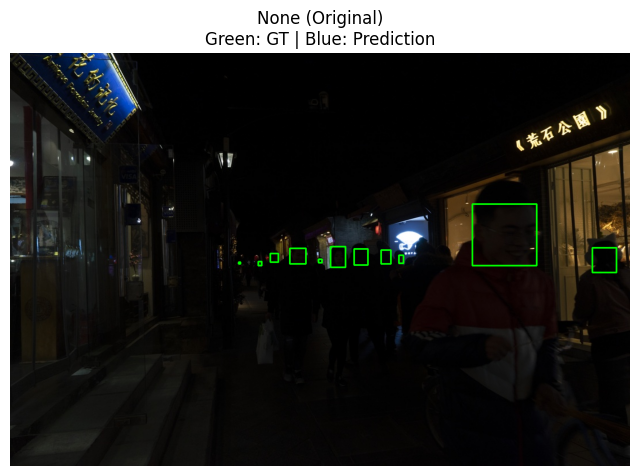

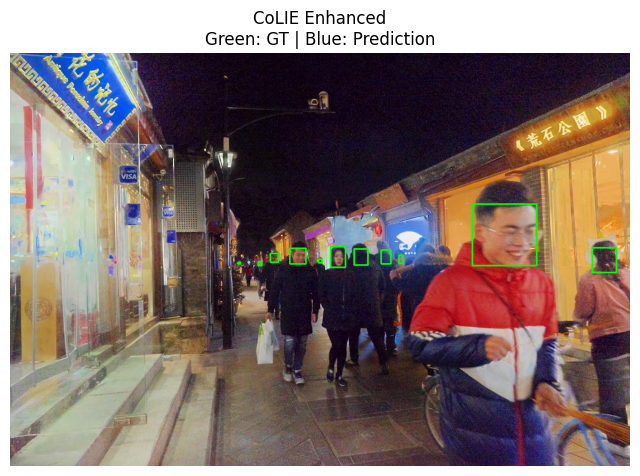

In [78]:
import cv2
import matplotlib.pyplot as plt

def show_prediction_vs_gt(image_path, pred_boxes, gt_boxes, title=""):
    if not os.path.exists(image_path):
        print(f"[ERROR] Image not found: {image_path}")
        return

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if gt_boxes is None:
        gt_boxes = []
    if pred_boxes is None:
        pred_boxes = []

    for box in gt_boxes:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)  # Green = GT

    for box in pred_boxes:
        box = [int(v) for v in box]
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)  # Blue = Prediction

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{title}\nGreen: GT | Blue: Prediction")
    plt.show()
image_file = "1.jpg"

img_path_none = "output/enhanced_images/original/" + image_file
img_path_collie = "output/enhanced_images/CoLIE/" + image_file

# Display side-by-side for comparison
show_prediction_vs_gt(img_path_none, pred_boxes.get("none", {}).get(image_file, []), gt_boxes.get(image_file, []), title="None (Original)")
show_prediction_vs_gt(img_path_collie, pred_boxes.get("CoLIE", {}).get(image_file, []), gt_boxes.get(image_file, []), title="CoLIE Enhanced")
